# Look of FrozenLake

In [ ]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
env = gym.make("FrozenLake-v1", desc=generate_random_map(size=4), map_name="4x4", is_slippery=True, render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(100):
   action = env.action_space.sample()  # this is where you would insert your policy
   # observation, reward, terminated, truncated, info = env.step(action)
   state = env.step(action)
   observation, reward, terminated, truncated, info = state
   print(state)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

# QLearning Algorithm

### Train

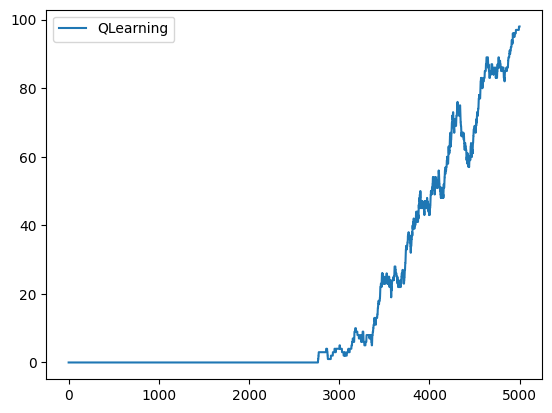

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

def QLearning(episodes, env_seed):

    env = gym.make("FrozenLake-v1", desc=env_seed, map_name="12x12", is_slippery=False, render_mode=None)

    q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 64 x 4 array

    learning_rate_a = 0.9 # alpha or learning rate
    discount_factor_g = 0.9 # gamma or discount rate. Near 0: more weight/reward placed on immediate state. Near 1: more on future state.
    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 1/episodes   # epsilon decay rate. 1/0.0001 = 10,000
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        while(not terminated and not truncated):
            if rng.random() < epsilon:
                action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
            else:
                action = np.argmax(q[state,:])

            new_state,reward,terminated,truncated,_ = env.step(action)
            if reward == 1:
                reward = 0
            elif terminated:
                reward = -99
            else:
                reward = -1

            # QLearning Algorithm
            q[state,action] = (1-learning_rate_a) * q[state,action] + learning_rate_a * (
                reward + discount_factor_g * np.max(q[new_state,:])
            )

            state = new_state

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if(epsilon==0):
            learning_rate_a = 1/episodes

        if reward == 0:
            rewards_per_episode[i] = 1
    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

    plt.plot(sum_rewards, label="QLearning")
    plt.legend()

    plt.savefig('frozen_lake_QLearning.png')
    return q


env_seed = generate_random_map(size=12)
QLearning_model = QLearning(5000, env_seed)

### Test

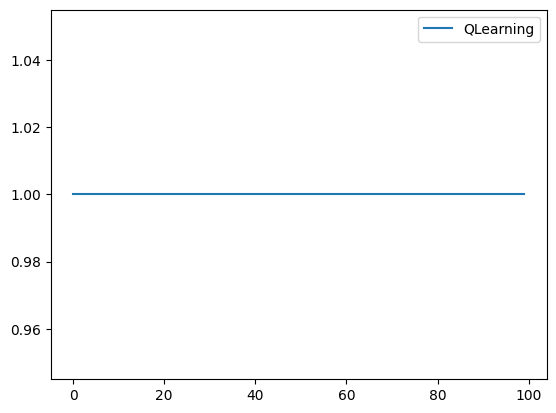

In [2]:
def seeModel(model, env_seed):
    env = gym.make("FrozenLake-v1", desc=env_seed, map_name="8x8", is_slippery=False, render_mode="human")
    state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
    terminated = False      # True when fall in hole or reached goal
    truncated = False       # True when actions > 200
    while(not terminated and not truncated):
        action = np.argmax(model[state,:])
        new_state,reward,terminated,truncated,_ = env.step(action)
        state = new_state
    env.close()

def testModel(model, model_name, env_seed, tests, line_style=None):
    rewards_per_episode = np.zeros(tests)
    env = gym.make("FrozenLake-v1", desc=env_seed, map_name="8x8", is_slippery=False, render_mode=None)
    for i in range(tests):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200
        while(not terminated and not truncated):
            action = np.argmax(model[state,:])
            new_state,reward,terminated,truncated,_ = env.step(action)
            state = new_state

            if reward == 1:
                reward = 0
            elif terminated:
                reward = -99
            else:
                reward = -1

        if reward == 0:
            rewards_per_episode[i] = 1
    env.close()
    plt.plot(rewards_per_episode, label=model_name, linestyle=line_style)
    plt.legend()

testModel(QLearning_model, "QLearning", env_seed, 100)
seeModel(QLearning_model, env_seed)

# SARSA

### Train

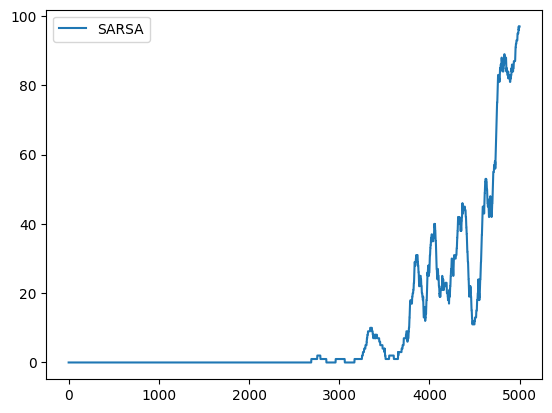

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

def SARSA(episodes, env_seed):

    env = gym.make("FrozenLake-v1", desc=env_seed, map_name="12x12", is_slippery=False, render_mode=None)

    q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 64 x 4 array

    learning_rate_a = 0.5 # alpha or learning rate
    discount_factor_g = 0.99 # gamma or discount rate. Near 0: more weight/reward placed on immediate state. Near 1: more on future state.
    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 1/episodes   # epsilon decay rate. 1/0.0001 = 10,000
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        if rng.random() < epsilon:
            action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
        else:
            action = np.argmax(q[state,:])
        while(not terminated and not truncated):
            new_state,reward,terminated,truncated,_ = env.step(action)
            if rng.random() < epsilon:
                new_action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
            else:
                new_action = np.argmax(q[new_state,:])

            if reward == 1:
                reward = 0
            elif terminated:
                reward = -99
            else:
                reward = -1

            q[state,action] = (1-learning_rate_a) * q[state,action] + learning_rate_a*(reward + discount_factor_g*q[new_state,new_action])
            state = new_state
            action = new_action

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if(epsilon==0):
            learning_rate_a = 1/episodes

        if reward == 0:
            rewards_per_episode[i] = 1
    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

    plt.plot(sum_rewards, label="SARSA")
    plt.legend()

    plt.savefig('frozen_lake_SARSA.png')
    return q


env_seed = generate_random_map(size=12)
Sarsa_model = SARSA(5000, env_seed)

### Test

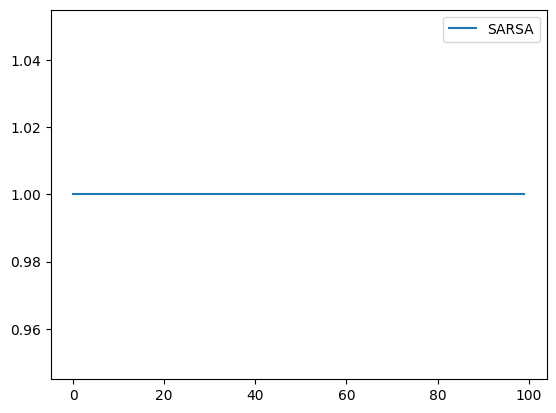

In [4]:
testModel(Sarsa_model, "SARSA", env_seed, 100)
seeModel(Sarsa_model, env_seed)

# Compare Both Models

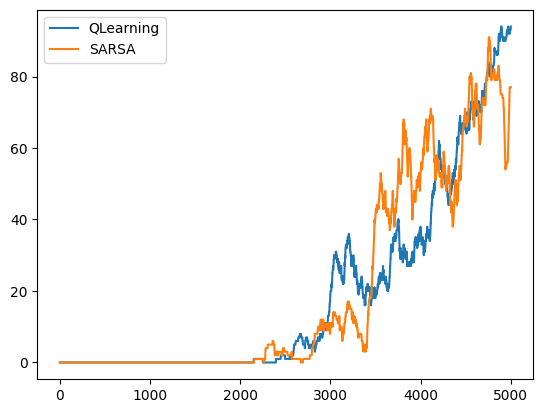

In [5]:
env_seed = generate_random_map(size=12)
QLearning_model = QLearning(5000, env_seed)
Sarsa_model = SARSA(5000, env_seed)
seeModel(QLearning_model, env_seed)
seeModel(Sarsa_model, env_seed)

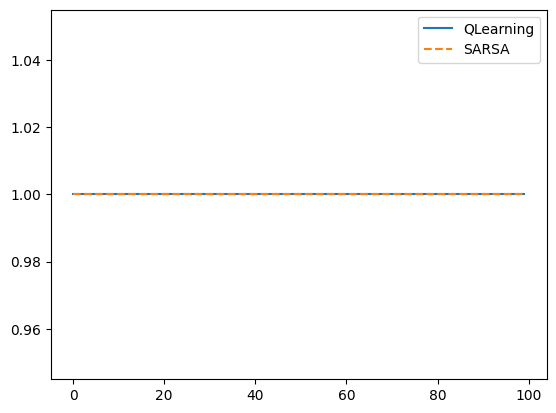

In [6]:
testModel(QLearning_model, "QLearning", env_seed, 100)
testModel(Sarsa_model, "SARSA", env_seed, 100, line_style="dashed")
# TODO Make GIF AND README